# Predicting the Volume of House Sales in NI Using a Seasonal ARIMA Model

The goal of this model is to provide an accurate prediction of the volume of house sales in Northern Ireland up to 12 months ahead.

This can be achieved by building a time series prediction model which will forecast the future of the housing market. Since the volume of house sales is a classic case of data that exhibits a seasonal trend, the model type chosen is a 'Seasonal ARIMA' model. This stands for Seasonal **A**uto**R**egressive **I**ntegrated **M**oving **A**verage model.

This type of model is created based on three components:
1. An Autoregressive Component: Future values are influenced by past values of the time series.
2. A Moving Average Component: The time series follows a long term trend linked to some length of a moving average.
3. A Seasonal Component: The data follows a predictable seasonal pattern.

The model will be built using data from 2005 to 2018, and tested on the real data for house sales observed in 2019.

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns

The dataset used is the 'Monthly property transactions completed in the UK' which is sourced from HM Revenue & Customs. This covers residential property transactions with a value of £40,000 or above.

Source data can be found here: https://www.gov.uk/government/statistics/monthly-property-transactions-completed-in-the-uk-with-value-40000-or-above

I have altered the dataset to only show transactions for property in Northern Ireland for the period April-2005 to December 2019.

In [109]:
df = pd.read_excel('NIHouseSalesData.xls',index_col='Date')
df.head()

,NorthernIreland
Date,
2005-04-01,3290
2005-05-01,3260
2005-06-01,3790
2005-07-01,3710
2005-08-01,3910


The data for 2019 is dropped as this will be used as the validation set of the data to test the models ability to accurately forecast the volume of house sales.

In [110]:
df.tail(12)

,NorthernIreland
Date,
2019-01-01,1730
2019-02-01,2070
2019-03-01,2240
2019-04-01,2020
2019-05-01,2450
2019-06-01,2290
2019-07-01,2170
2019-08-01,2690
2019-09-01,2410


In [111]:
df.drop(df.tail(12).index,inplace=True)
df.tail()

,NorthernIreland
Date,
2018-08-01,2830
2018-09-01,2220
2018-10-01,2560
2018-11-01,2820
2018-12-01,2320


# Plot Data
The data is plotted to show the trend over time which shows two periods of note:

## 2007-2009 (Highlighted in red):

A huge reduction in property transactions during the financial crisis.

## March/April 2016 (Highlighted in grey):

The UK government announced an that in April, stamp duty would be increased by 3% for purchases of second homes. This led to a March rush and a subsequent April lull in purchases of buy-to-let properties 

(Office for National Statistics report, 2016: https://www.ons.gov.uk/peoplepopulationandcommunity/housing/articles/theeffectofstampdutychangesonhousingmarketactivity/september2016)

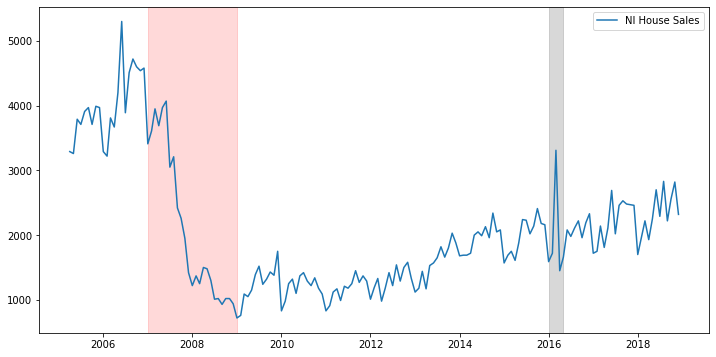

In [112]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df['NorthernIreland'],label='NI House Sales')
ax.legend()

#Highlighting 2007 - 2009
a = pd.to_datetime('2007-01')
b = pd.to_datetime('2009-01')
ax.axvspan(a,b,alpha=0.15,color='red')

#Highlighting Feb - May 2016
c = pd.to_datetime('2016-01')
d = pd.to_datetime('2016-05')
ax.axvspan(c,d,alpha=0.3,color='grey')

## Plot with Rolling Mean
The data can be plotted with a 12-month rolling mean in an attempt to remove the seasonality and view the general trend over time.

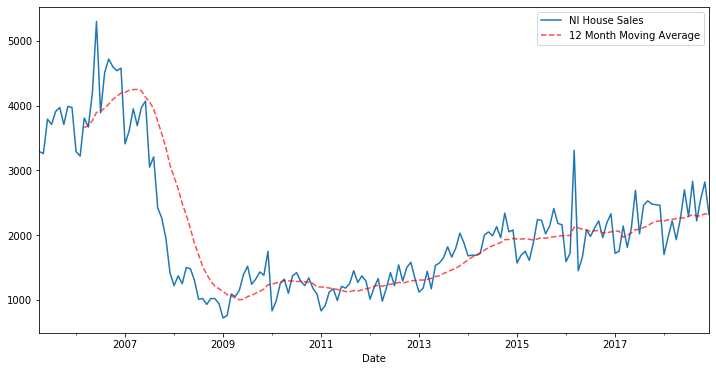

In [113]:
df['NorthernIreland'].plot(figsize=(12,6),label='NI House Sales')
df['NorthernIreland'].rolling(12).mean().plot(label='12 Month Moving Average',color='red',ls='--',alpha=0.7)
plt.legend()

The twelve month moving average of the time series shows that since the financial crisis, the volume of house sales in Northern Ireland has been trending steadily upwards in what looks to be a predictable fashion.

##  Error - Trend - Seasonal (ETS) Decomposition
House sales volume is a classic case of seasonal data, more houses are sold in the spring and summer than are sold in the autumn and winter. This is mentioned by HMRC in the download of the original dataset

The time series is decomposed into it's three underlying components:
1. **Trend:**
    The long term progression of the series across time.
2. **Seasonal:**
    The pattern of the series across seasons (in this case months).
3. **Error:**
    The residual differences in the time series which are not explained by the general trend, or the season.

In [114]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['NorthernIreland'],model='additive')

## Trend

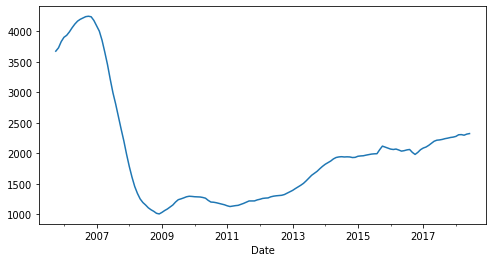

In [115]:
fig = result.trend.plot(figsize=(8,4))

After the financial crisis in 2007-08 there was a huge crash in housing sales volume in Northern Ireland. Since then, there has been a general upward trend in the volume of house sales which looks to be more or less linear.

## Seasonality

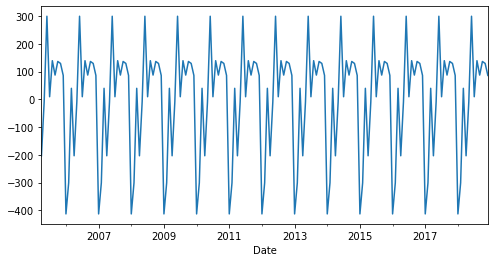

In [116]:
result.seasonal.plot(figsize=(8,4))

As expected the data is highly seasonal, with high sales volume in the summer months and low sales volume in the winter months.

## Error

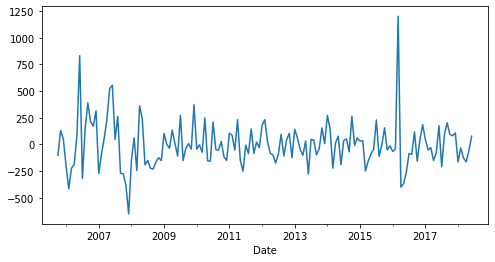

In [117]:
result.resid.plot(figsize=(8,4))

Aside from the two time periods mentioned previously (2007-09 and early 2016) the error values look to be random. This means that the data lends itself to being forecasted using an model which takes into account some general trend factor, as well as a seasonality factor.

## Stationarity
To forecast future house sales volume using an ARIMA model, the data must be stationary. Stationarity can be achieved in seasonal data by seasonal differencing, for monthly data this is achieved by finding the difference between each data point and the data point 12 months previous

Text(0, 0.5, 'Volume')

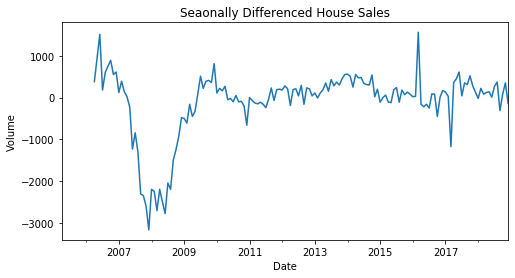

In [118]:
df['SeasonalDifference'] = df['NorthernIreland'] - df['NorthernIreland'].shift(12)
df['SeasonalDifference'].plot(figsize=(8,4))
plt.title('Seaonally Differenced House Sales')
plt.ylabel('Volume')

The seasonally adjusted data does not exhibit the characteristics of a stationary process as the mean and variance are not constant. This data is then first differenced in an attempt to achieve stationarity.

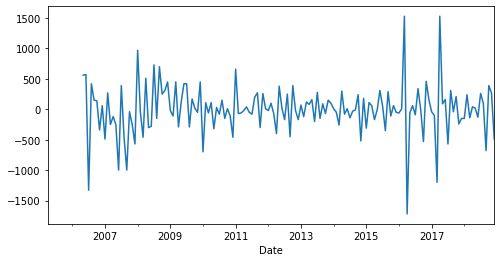

In [119]:
df['FDSeasonalDifference'] = df['SeasonalDifference'] - df['SeasonalDifference'].shift(1)
df['FDSeasonalDifference'].plot(figsize=(8,4))

Observing the seasonal first difference, this looks more like what we would expect a stationary process to look like; mean and variance both look to be constant over time aside from the large spike in 2016 when the stamp duty was increased.

The Augmented Dickey-Fuller Test can be used as a statistical test for stationarity in the data:

In [120]:
from statsmodels.tsa.stattools import adfuller

In [121]:
adf_result = adfuller(df['FDSeasonalDifference'].dropna())

In [122]:
print('Augmented Dickey Fuller Test - p-value = ' + str(adf_result[1]))

Augmented Dickey Fuller Test - p-value = 0.00032838734715832967


The p-value is less than 0.05, this is strong evidence against the null hypothesis of non-stationarity so we can say with 95% confidence that the seasonal first differenced data is stationary.

## Autocorrelation and Partial Autocorrelation Plots
After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether autoregressive (AR) or moving average (MA) terms are neededd to correct any autocorrelation that remains in the differenced series.

By looking at the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots of the differenced series, the numbers of AR and/or MA terms can be tentatively identified.

The ACF plot is a chart of the coefficients of correlation between a time series and lags of itself.

The PACF is a plot of the partial correlation coefficients between a time series and lags of itself. This is the amount of variation between a variable and a lag of itself that is not explained by correlations at all lower lags.

In [123]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

Here is the ACF of the Northern Ireland house sales volume series before any differencing is performed.

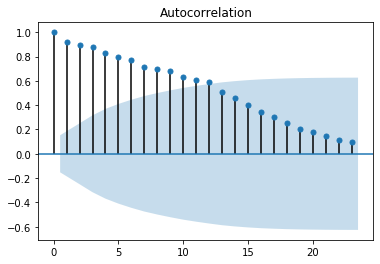

In [124]:
fig_df = plot_acf(df['NorthernIreland'].dropna())

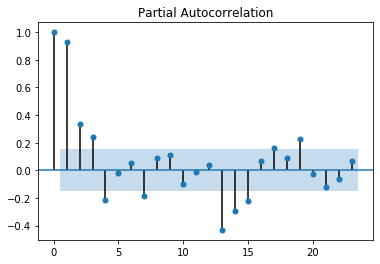

In [125]:
fig_df_pacf = plot_pacf(df['NorthernIreland'].dropna())

### 'Seasonal Random Trend Model'
The ACF plot above shows high correlation at up to twelve lags in the data, indicating the seasonal nature of the data and supporting the use of seasonal differencing.

The PACF plot above shows high correlation at the first partial lag of the data, indicating that a first difference in the seasonal difference is required.

The ACF and PACF plots of the first difference of the seasonal difference in the data are plotted below, these plots show very little autocorrelation or partial autocorrelation in the differenced data.

These plots support the result from the Augmented Dickey-Fuller test above, that the data is best modelled after taking the first difference of the seasonal difference. This is also known as a 'Seasonal Random Trend Model'.

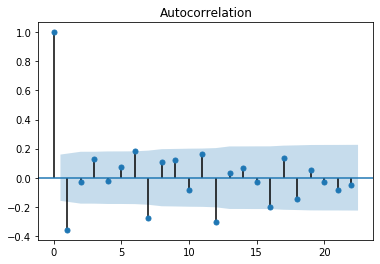

In [126]:
fig_FDS = plot_acf(df['FDSeasonalDifference'].dropna())

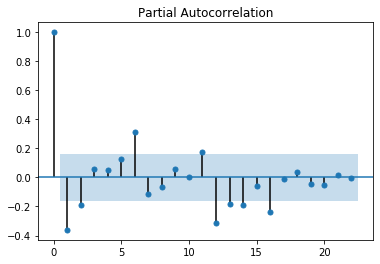

In [127]:
fig_FDS_pacf = plot_pacf(df['FDSeasonalDifference'].dropna())

## Step 6: ARIMA Model
Observing stationarity in the seasonal first difference of the data means that the time series lends itself to being forecasted using a seasonal random trend model.

This type of model assumes that the seasonal trend observed this month is a random step away from the trend that was observed last month, where the steps are assumed to have a mean of zero.

The seasonal random trend model assumes that the expected value of all future seasonal differences are equal to the most recently observed seasonal difference. This model also assumes that the actual seasonal differences will be undergoing a zero-growth random walk.

A seasonal random trend model is an ARIMA(0,1,0)x(0,1,0) model.

In [128]:
model1 = sm.tsa.statespace.SARIMAX(df['FDSeasonalDifference'],order=(0,1,0),seasonal_order=(0,1,0,12))
results1 = model1.fit()
print(results1.summary())

                                     SARIMAX Results                                      
Dep. Variable:               FDSeasonalDifference   No. Observations:                  165
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1280.713
Date:                            Tue, 28 Jul 2020   AIC                           2563.427
Time:                                    14:52:18   BIC                           2566.450
Sample:                                04-01-2005   HQIC                          2564.655
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.108e+06   6.02e+04     18.421      0.000     9.9e+05    1.23e+06
Ljung-Box (Q):                     

C:\Users\Michael\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michael\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


## Second Model for Comparison
Looking back at the ACF and PACF plots for the first difference of the seasonally differenced data, it is noted that there is a negative spike in the ACF at lag 1, and also a negative spike in the ACF at lag 12. The PACF on the other hand shows a more gradual decay pattern in the vicinity of both of these lags. 

Referencing common rules for identifying ARIMA models, this seasonal random trend model should be improved by the addition of an MA(1) term as well as an SMA(1) term.

Thus, we obtain the ARIMA(0,1,1)x(0,1,1) model, which happens to be the most commonly used seasonal ARIMA model.

Both of these models will be tested and compared against each other before the best model is selected.

In [129]:
model2 = sm.tsa.statespace.SARIMAX(df['NorthernIreland'],order=(0,1,1),seasonal_order=(0,1,1,12))
results2 = model2.fit()
print(results2.summary())

C:\Users\Michael\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Michael\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                    NorthernIreland   No. Observations:                  165
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1091.200
Date:                            Tue, 28 Jul 2020   AIC                           2188.401
Time:                                    14:52:20   BIC                           2197.473
Sample:                                04-01-2005   HQIC                          2192.086
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3910      0.048     -8.137      0.000      -0.485      -0.297
ma.S.L12      -0.8366      0.113   

## Comparing The Models
These two models can be compared initially by plotting the ACF plots of their residuals next to each other to observe if there is any autocorrelation in the residuals.

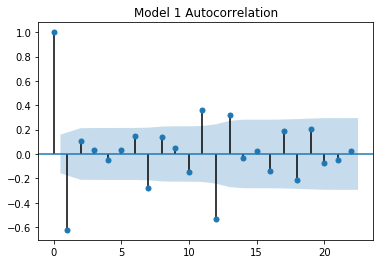

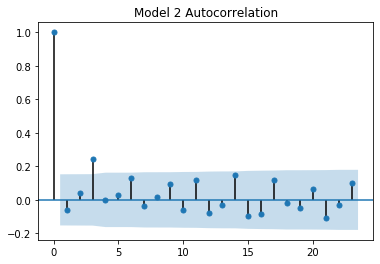

In [130]:
ax1 = plot_acf(results1.resid.dropna(),title='Model 1 Autocorrelation')
ax2 = plot_acf(results2.resid.dropna(),title='Model 2 Autocorrelation')

Model 2 looks to show less significant autocorrelation in the residuals than model 1.

To check the goodness of fit of the models to the data, the residuals can be plotted on the same chart:

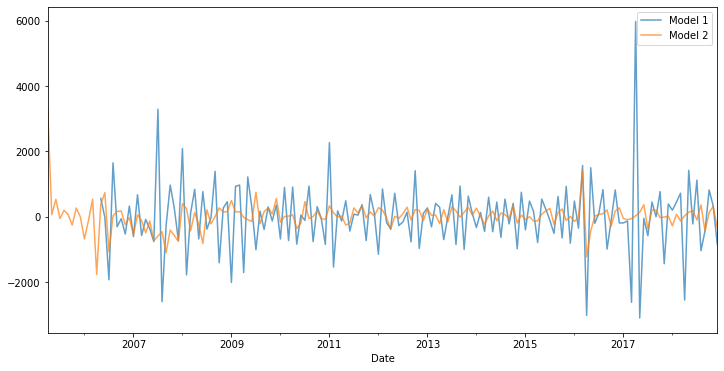

In [131]:
results1.resid.plot(figsize=(12,6),alpha=0.7,label='Model 1')
results2.resid.plot(alpha=0.7,label='Model 2')
plt.legend()

Here, model 2 looks to have a better fit to the data as the residuals show less extreme values and are more centred around 0. This can be shown from plotting the kernel density plots of the residuals on the same chart:

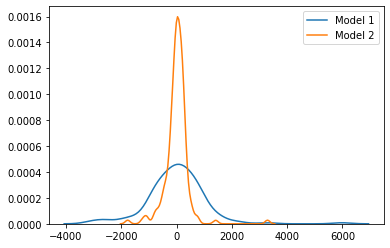

In [132]:
sns.kdeplot(results1.resid,label='Model 1')
sns.kdeplot(results2.resid,label='Model 2')

Once again, the superiority of model 2 is shown as the kernal density plot has a higher peak and smaller tails, and is centred around 0.

The Akaike Information Criteria (AIC) provided by the models can be used as a means for comparison. The AIC is a score that can be used to determine which model is most likely to be the best model for a given dataset, and the lower the score the better.

In [133]:
print('Model 1 AIC: ' + str(results1.aic))
print('Model 2 AIC: ' + str(results2.aic))

Model 1 AIC: 2563.4265252331743
Model 2 AIC: 2188.4008781219336


Model 2 has a lower AIC and so should be used ahead of model 1 when predicting the volume of house sales in Northern Ireland.

# Step 7: Forecasting

Now that Model 2 has been selected as the preferred model, it will be used to forecast the volume of house sales in Northern Ireland for 2019 and compared against the actual numbers.

First, the forecasting dates need to be added to the Pandas Dataframe

In [134]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1,13) ]
future_dates

[Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-12-01 00:00:00')]

In [135]:
future_df = pd.DataFrame(index=future_dates[0:],columns=df.columns)
future_df = pd.concat([df,future_df])

In [136]:
future_df.tail(14)

,NorthernIreland,SeasonalDifference,FDSeasonalDifference
2018-11-01,2820,350.0,270.0
2018-12-01,2320,-140.0,-490.0
2019-01-01,NaN,NaN,NaN
2019-02-01,NaN,NaN,NaN
2019-03-01,NaN,NaN,NaN
2019-04-01,NaN,NaN,NaN
2019-05-01,NaN,NaN,NaN
2019-06-01,NaN,NaN,NaN
2019-07-01,NaN,NaN,NaN
2019-08-01,NaN,NaN,NaN


Now the forecasted values are added to the dataframe and plotted alongside the training data to observe the predictions.

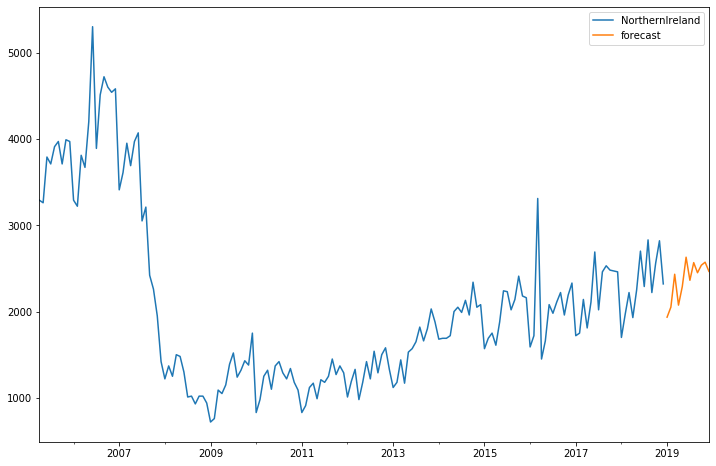

In [137]:
future_df['forecast'] = results2.predict(start = 165, end = 177, dynamic= True)
future_df[['NorthernIreland','forecast']].plot(figsize=(12,8))

The predictions look like they make sense as they have a lull in the winter months and a spike in the summer months, all while exhibiting a general trend upwards in the volume of house sales.

Now the forecasted values can be compared to the actual values observed in 2019.

In [138]:
full_df = pd.read_excel('NIHouseSalesData.xls',index_col='Date')

In [139]:
full_df = pd.concat([full_df,future_df['forecast']],axis=1)

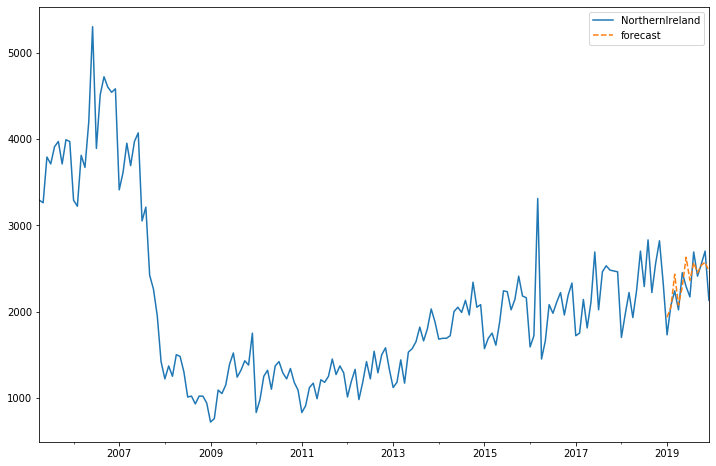

In [140]:
full_df.plot(figsize=(12,8),style=['-','--'])

Zooming in on 2019 gives a better picture of how the model performed in its predictions.

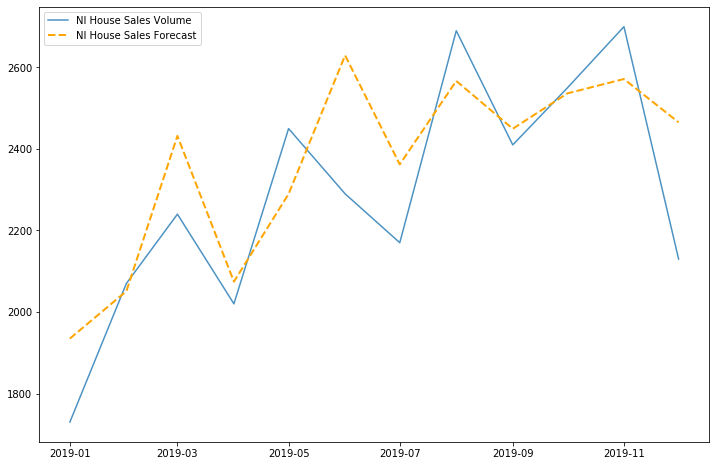

In [141]:
fig = plt.figure(figsize=(12,8))

plt.plot(full_df.index[165:],full_df['NorthernIreland'][165:],label='NI House Sales Volume',alpha=0.8)
plt.plot(future_df.index[165:],future_df['forecast'][165:],label='NI House Sales Forecast',color='orange',ls='--',lw=2)
plt.legend()

The predicted values look to provide a good estimate of the data when compared to the values that were actually observed in the test set.

This error level can be quantified by calculating the average percentage difference in the predicted values versus the actual values.

In [142]:
full_df['forecast_error'] = full_df['forecast'] - full_df['NorthernIreland']

In [143]:
full_df['forecast_error_pct'] = full_df['forecast_error'] / full_df['NorthernIreland'] * 100

In [144]:
full_df.tail(15)

,NorthernIreland,forecast,forecast_error,forecast_error_pct
2018-10-01,2560,NaN,NaN,NaN
2018-11-01,2820,NaN,NaN,NaN
2018-12-01,2320,NaN,NaN,NaN
2019-01-01,1730,1934.780066,204.780066,11.836998
2019-02-01,2070,2051.076126,-18.923874,-0.914197
2019-03-01,2240,2432.064688,192.064688,8.574316
2019-04-01,2020,2074.448204,54.448204,2.695456
2019-05-01,2450,2289.624618,-160.375382,-6.545934
2019-06-01,2290,2629.511256,339.511256,14.825819
2019-07-01,2170,2362.133041,192.133041,8.854057


In [145]:
full_df['forecast_error_pct'].mean()

3.9037045875846808

## Summary

Overall, the seasonal ARIMA model provides accurate predictions for the volume of house sales in Northern Ireland 12 months ahead. The average percentage difference between the forecast volume and the actual volume for 2019 was 3.9%.

This model will obviously struggle to predict the volume of house sales for 2020 due to the coronavirus pandemic resulting in a lockdown in Northern Ireland - the housing market was effectively closed for around two months. The result of this is that there were two months with nearly 0 sales, followed by a spike in sales when the market reopened due to the pent-up demand.